<a href="https://colab.research.google.com/github/AustralianSDAF/cnn-land-cover-classification/blob/main/Making_Predictions_Land_Cover_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Land cover classification using Convolutional Neural Networks (CNNs)
## Inference – Making Predictions
Inference is applying a trained model to make predictions on new observations or images in this case.

In this notebook, we will load our trained model and use it to make predictions on a Sentinel-2 image of Perth Western Australia.

The image we will make predictions on has a dimension of `10980 x 10980` pixels or `[10980, 10980, 13]`. However, recall that our model was trained on images of `64 x 64` pixels (`[64, 64, 13]`. As a result, before we can feed the image into our trained model, we have to first divide into multiple subsets with the size of `64 x 64 pixels`.

Specifically, this notebook will walk you through the following steps:
1. Read the Sentinel-2 image from Google Drive into memory
2. Resample all the bands of the image so they have the same dimensions, `10980x10980 pixels`, ([each band of Sentinel-2 images has a different spatial resolution](https://sentinels.copernicus.eu/web/sentinel/missions/sentinel-2/instrument-payload/resolution-and-swath); thus different dimensions). 
3. Divide our image into `64x64` tiles
4. Load our trained model
5. Predict the land cover type of each `64x64` tile of our `10980x10980` image.
6. Visualise the land cover types

#### Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Run the helper function notebook so we use the functions in this notebook

In [ ]:
%run /content/drive/MyDrive/Colab\ Notebooks/Helper\ Functions\ -\ Land\ Cover\ Classification.ipynb

### Rasterio

Geographic information systems use GeoTIFF and other formats to organize and store gridded, or raster, datasets, such as Sentinel-2 images. Rasterio is a Python package that allows you to read and write these data.



#### Install Rasterio

In [ ]:
!pip install rasterio

     |████████████████████████████████| 19.3 MB 1.4 MB/s 


#### Import Libraries

In [ ]:
import rasterio #rasterio for reading and writing raster datasets
import matplotlib.pyplot as plt #matplotlib for visualisation
import numpy as np #numpy for manipulating numpy arrays
import tensorflow as tf #tensorflow for loading a saved model and making predictions
from scipy import ndimage, misc #ndimage for resampling satellite imagery


#### Opening and Reading Imagery Using Rasterio

In [ ]:
"""
Rasterio’s open() function takes a path string or path-like object and returns an opened dataset object. 
The path may point to a file of any supported raster format. 
Rasterio will open it using the proper GDAL format driver. 
Dataset objects have some of the same attributes as Python file objects.
"""

imagepath = '/content/drive/MyDrive/Colab Notebooks/LandCoverClassification/Inference_Data/' #root file path
band1_file = rasterio.open(imagepath+'T50HLK_20201222T021339_B01.jp2', driver='JP2OpenJPEG') #path to band 1 of Sentinel-2 image
band2_file = rasterio.open(imagepath+'T50HLK_20201222T021339_B02.jp2', driver='JP2OpenJPEG') #blue band
band3_file = rasterio.open(imagepath+'T50HLK_20201222T021339_B03.jp2', driver='JP2OpenJPEG') #green band
band4_file = rasterio.open(imagepath+'T50HLK_20201222T021339_B04.jp2', driver='JP2OpenJPEG') #red band
band5_file = rasterio.open(imagepath+'T50HLK_20201222T021339_B05.jp2', driver='JP2OpenJPEG') 
band6_file = rasterio.open(imagepath+'T50HLK_20201222T021339_B06.jp2', driver='JP2OpenJPEG') 
band7_file = rasterio.open(imagepath+'T50HLK_20201222T021339_B07.jp2', driver='JP2OpenJPEG') 
band8_file = rasterio.open(imagepath+'T50HLK_20201222T021339_B08.jp2', driver='JP2OpenJPEG') 
band8a_file= rasterio.open(imagepath+'T50HLK_20201222T021339_B8A.jp2', driver='JP2OpenJPEG') 
band9_file = rasterio.open(imagepath+'T50HLK_20201222T021339_B09.jp2', driver='JP2OpenJPEG') 
band10_file  = rasterio.open(imagepath+'T50HLK_20201222T021339_B10.jp2', driver='JP2OpenJPEG') 
band11_file = rasterio.open(imagepath+'T50HLK_20201222T021339_B11.jp2', driver='JP2OpenJPEG') 
band12_file = rasterio.open(imagepath+'T50HLK_20201222T021339_B12.jp2', driver='JP2OpenJPEG') 


In [ ]:
"""
Data from a raster band can be accessed using the `read()` function by the band’s index number. Following the GDAL convention, bands are indexed from 1.
"""
band1 = band1_file.read(1) #read band 1
band2 = band2_file.read(1) #read band 2
band3 = band3_file.read(1) # read band 3
band4 = band4_file.read(1) # etc.
band5 = band5_file.read(1)
band6 = band6_file.read(1)
band7 = band7_file.read(1)
band8 = band8_file.read(1)
band8a = band8a_file.read(1)
band9 = band9_file.read(1)
band10 = band10_file.read(1)
band11 = band11_file.read(1)
band12 = band12_file.read(1)

Let's examine the dimensions of each band using numpy's `.shape` method.

As you can see, each band of a Sentinel-2 image has a different spatial resolutions and thus different dimensions.

In [ ]:
print(band1.shape)
print(band2.shape)
print(band3.shape)
print(band4.shape)
print(band5.shape)
print(band6.shape)
print(band7.shape)
print(band8.shape)
print(band8a.shape)
print(band9.shape)
print(band10.shape)
print(band11.shape)
print(band12.shape)

(1830, 1830)
(10980, 10980)
(10980, 10980)
(10980, 10980)
(5490, 5490)
(5490, 5490)
(5490, 5490)
(10980, 10980)
(5490, 5490)
(1830, 1830)
(1830, 1830)
(5490, 5490)
(5490, 5490)


Before we can make predictions on the image, we have to resample each band. In other words, we have bring all bands to the same spatial resolution and dimension.

This can be achieved using `scipy`'s `ndimage` module. 

#### Import libraries

In [ ]:
from scipy import ndimage, misc
import numpy as np
import matplotlib.pyplot as plt

The `zoom` function of the `ndimage` zooms an array using spline interpolation of the requested order. It takes two inputs:
- `input` – the input array
- `zoom` – The zoom factor along the axes. 

For Sentinel-2 images, we want all bands to have `10980x10980` pixels dimensions. As such, the first band (`1830x1830`) has to be zoomed in by a factor of 6, the fifth band (`5490x5490`) by a factor of 2, etc.

In [ ]:
band1_10m = ndimage.zoom(band1, 6)
band5_10m = ndimage.zoom(band5, 2)
band6_10m = ndimage.zoom(band6, 2)
band7_10m = ndimage.zoom(band7, 2)
band8a_10m = ndimage.zoom(band8a, 2)
band9_10m = ndimage.zoom(band9, 6)
band10_10m = ndimage.zoom(band10, 6)
band11_10m = ndimage.zoom(band11, 2)
band12_10m = ndimage.zoom(band12, 2)

Let's print the dimension of each band after the interpolation.

As can be seen, all bands have the same dimension now. We are almost ready to make predictions on the image. There's one more preprocessing step remaining..

In [ ]:
print(band1_10m.shape)
print(band2.shape)
print(band3.shape)
print(band4.shape)
print(band5_10m.shape)
print(band6_10m.shape)
print(band7_10m.shape)
print(band8.shape)
print(band8a_10m.shape)
print(band9_10m.shape)
print(band10_10m.shape)
print(band11_10m.shape)
print(band12_10m.shape)

(10980, 10980)
(10980, 10980)
(10980, 10980)
(10980, 10980)
(10980, 10980)
(10980, 10980)
(10980, 10980)
(10980, 10980)
(10980, 10980)
(10980, 10980)
(10980, 10980)
(10980, 10980)
(10980, 10980)


Our model was trained on the EuroSAT dataset and the order of the bands in the EuroSAT images are:

`[b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11,b12, b8a]`

To ensure our model can make accurate predictions on our inference image, we have stack the bands of the input image in the same order.

In [ ]:
# define a numpy array with dimensions 10980x10980x13
all_bands_arr = np.zeros((10980, 10980, 13),dtype=np.uint16) 

In [ ]:
all_bands_arr[:, :, 0] = band1_10m[:, :] # band 1
all_bands_arr[:, :, 1] = band2[:, :] #band 2
all_bands_arr[:, :, 2] = band3[:, :] #band 3
all_bands_arr[:, :, 3] = band4[:, :] # etc.
all_bands_arr[:, :, 4] = band5_10m[:, :]
all_bands_arr[:, :, 5] = band6_10m[:, :]
all_bands_arr[:, :, 6] = band7_10m[:, :]
all_bands_arr[:, :, 7] = band8[:, :]
all_bands_arr[:, :, 8] = band9_10m[:, :]
all_bands_arr[:, :, 9] = band10_10m[:, :]
all_bands_arr[:, :, 10] = band11_10m[:, :]
all_bands_arr[:, :, 11] = band12_10m[:, :]
all_bands_arr[:, :, 12] = band8a_10m[:, :] # band 8a


Let's visualise one pixel of the image.

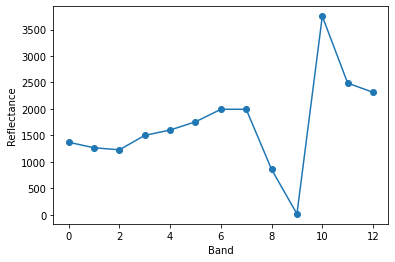

In [ ]:
plt.ylabel("Reflectance")
plt.xlabel('Band')
plt.plot(all_bands_arr[10000,10000,:],'-o')

We are finally ready to make predictions on our image. Preprocessing is an important part of machine learning projects. It ensure our data is less noisy and that our models are able to learn easily from the input data and make accurate predictions. It is not uncommon for the preprocessing step to take up to 90% of the total development time. 

First, we need to load our pretrained model. This is done using the Keras `.load_model()` function.

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/LandCoverClassification/TrainedModel/land_cover_classification_pretrained.h5')
model.summary() #print the content of the model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        3776      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 128)       1

Run the `sliding()` function from the Helper Notebook to break the image into tiles of `64x64` pixels.

In [ ]:
"""
Here we run the sliding() function to break our input image into many 64x64 tiles
We also define the relevant variables such as batch_size, total_chips, and num_steps for our inference step below
"""
windows = sliding((10980,10980), 64, fixed=True) #return tiles of 64x64 from the input image
windows_ = iter(windows)  # The Python iter() function returns an iterator for the given object, in this case windows
windows_class = iter(windows) 

batch_size = 10 #batch size to use for each iteration of inference
total_chips = len(windows) #total tiles of 64x64
num_steps = int(total_chips / batch_size)

In [ ]:
print('Prediciting ...')

"""
This sliding algorithm has been written by Nicolò Taggio for 
N. Taggio, ‘Artificial Intelligence (AI) for Earth Monitoring’.
"""

img_classes = np.zeros((10980, 10980), dtype=np.uint16) #numpy array to store image classes for each pixel of the new image
progbar = tf.keras.utils.Progbar(num_steps) #keras module to show progress bar when making predictions

predictions = []
"""
Go through each tile in the image and classify the tile using the trained model
"""
for b in range(num_steps):
    chips = np.empty([batch_size, 64, 64, 13])
    for k in range(batch_size):
        ymin, xmin, xmax, ymax = next(windows_)
        chips[k] = all_bands_arr[xmin:xmin+xmax, ymin:ymin+ymax, :]        
    
    preds = model.predict(chips)
    predictions.append(np.argmax(preds, axis=-1))
    for i in range(0, batch_size):
        ymin_cl, xmin_cl, xmax_cl, ymax_cl = next(windows_class)
        img_classes[xmin_cl:xmin_cl+xmax_cl, ymin_cl:ymin_cl+ymax_cl] = predictions[b][i]
    progbar.update(b + 1)

Prediciting ...
2924/2924 [==============================] - 211s 69ms/step


#### Visualise Predictions

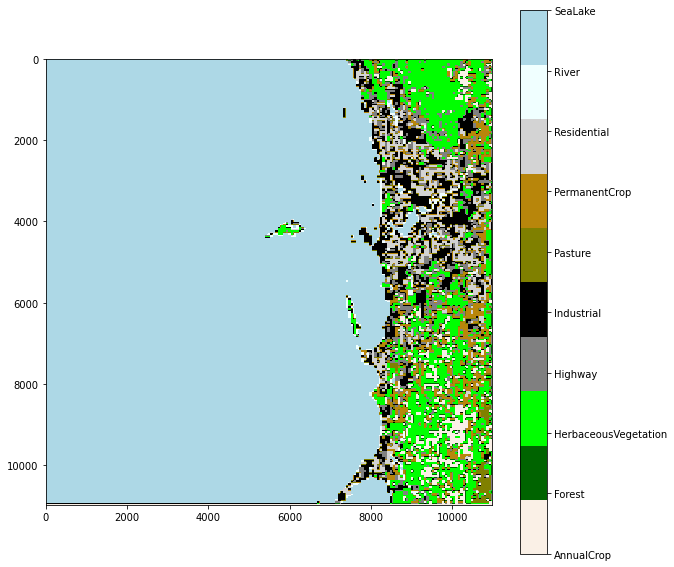

In [ ]:
from matplotlib.colors import LinearSegmentedColormap #import library

plt.figure().clear() #clear figure

label=['AnnualCrop','Forest','HerbaceousVegetation','Highway','Industrial',
       'Pasture','PermanentCrop','Residential','River','SeaLake'] #labels

cmap = LinearSegmentedColormap.from_list(
    "", 
    ["linen","darkgreen","lime","grey","k",
     "olive","darkgoldenrod","lightgrey","azure","lightblue"], 
     N=10) #map labels to different colors

plt.figure(figsize=(10,10)) #instantite figure
plt.imshow(img_classes, cmap=cmap) #show image
cbar=plt.colorbar() #show color bar
cbar.ax.set_yticklabels(label) #set y tick labels
plt.show() #show plot

## Summary

In this tutorial, we learned how to load a dataset from the Tensorflow Datasets platform, prepare the data and split it into training and test sets, define a deep learning model, configure the model, train the model using training data, evaluated the trained model, and use it to make predictions on a new image.

Overall, we developed a very good model that is able to classify a land cover type with ~86% accuracy. This is not state of the art, but very good. Here's a few ways we can improve our model to reach an accuracy of up to 98%.

1. Use the whole EuroSAT dataset to train your model. The EuroSAT dataset contains 1,423 images per class. In our tutorial we were only able to use 35% of the training data (due to memory constraints). This means the images we used to train our model were not evenly distributed across all classes and this may have created some bias in our model. 
2. Use a larger model with more layers and layer capacities. Due to the computational limitations of Google Colab we were only able to build and train a small deep learning model. The larger the model, the more representation it is able to extract from the training data. However, be mindful that an overly complicated model can easily overfit. In other words, it will memorise all the patterns in the training data, but will fail to generalise well to new data. To mitigate overfitting, use the techniques we employed in the tutorial to monitor your validation loss and accurracy and stop training as soon as the validation loss diverge from the training loss. 
3. If you have access to larger computing infrastructures, build a model with the `ResNet-50` and `GoogLeNet` architectures. These two architectures have  already been fine-tuned to maximise image classification accuracy and reduce loss. In the original EuroSAT paper, when the EuroSAT data was used to train  `ResNet-50` and `GoogLeNet`, the models were able to reach validation accuracies of 98.57% and 98.18% respectively.